<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## Machine Learning
## Chapter5. Machine Learning
This chapter is about machine learning as a process. Although it uses specific algorithms and specific data for illustration, the notions and approaches discussed in this chapter are general in nature. The goal is to present the most important elements of machine learning in a single place and in an easy-to-understand and easy-to-visualize manner. The approach of this chapter is practical and illustrative in nature, omitting most technical details throughout. In that sense, the chapter provides a kind of blueprint for later, more realistic machine learning applications.

“Learning” briefly discusses the very notion of a machine that learns. “Data” imports and preprocesses the sample data used in later sections. The sample data is based on a time series for the EUR/USD exchange rate. “Success” implements OLS regression and neural network estimation given the sample data and uses the mean-squared error as the measure of success. “Capacity” discusses the role of the model capacity in making models more successful in the context of estimation problems. “Evaluation” explains the role that model evaluation, typically based on a validation data sub-set, plays in the machine-learning process. “Bias and Variance” discusses the notions of high bias and high variance models and their typical characteristics in the context of estimation problems. “Cross-Validation” illustrates the concept of cross-validation to avoid, among other things, overfitting due to a too-large model capacity.

VanderPlas (2017, ch. 5) discusses topics similar to the ones covered in this chapter, making use primarily of the scikit-learn Python package. Chollet (2017, ch. 4) also provides an overview similar to the one provided here, but primarily makes use of the Keras deep learning package. Goodfellow et al. (2016, ch. 5) give a more technical and mathematical overview of machine learning and related important concepts.


# Learning
On a formal, more abstract level, learning by an algorithm or computer program can be defined as in Mitchell (1997):


*A computer program is said to learn from experience E
 with respect to some class of tasks T
 and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.*
 
There is a class of tasks that are to be performed (for example, estimation or classification). Then there is a performance measure, such as the mean-squared error (MSE) or the accuracy ratio. Then there is learning as measured by the improvement in performance given the experience of the algorithm with the task. The class of tasks at hand is described in general based on the given data set, which includes the features data and the labels data in the case of supervised learning, or only the features data in the case of unsupervised learning.

LEARNING TASK VERSUS TASK TO LEARN
In the definition of learning through an algorithm or computer program, it is important to note the difference between the task of learning and the tasks to be learned. Learning means to learn how to (best) execute a certain task, such as estimation or classification.



Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

### Data
This section introduces the sample data set to be used in the sections to follow. The sample data is created based on a real financial time series for the EUR/USD exchange rate. First, the data is imported from a CSV file, and then the data is resampled to monthly data and stored in a Series object:

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
np.random.seed(100)
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)['EUR=']

In [4]:
raw.head()

Date
2010-01-01    1.4323
2010-01-04    1.4411
2010-01-05    1.4368
2010-01-06    1.4412
2010-01-07    1.4318
Name: EUR=, dtype: float64

In [5]:
raw.tail()

Date
2019-12-26    1.1096
2019-12-27    1.1175
2019-12-30    1.1197
2019-12-31    1.1210
2020-01-01    1.1210
Name: EUR=, dtype: float64

In [6]:
l = raw.resample('1M').last()

1. Imports the financial time series data

2. Resamples the data to monthly time intervals

In [7]:
l.plot(figsize=(10, 6), title='EUR/USD monthly');
# plt.savefig('../../images/ch05/figure_ml_01.png')

To have a single feature only, the following Python code creates a synthetic feature vector. This allows for simple visualizations in two dimensions. The synthetic feature (independent variable), of course, does not have any explanatory power for the EUR/USD exchange rate (labels data, dependent variable). In what follows, it is also abstracted from the fact that the labels data is sequential and temporal in nature. The sample data set is treated in this chapter as a general data set composed of a one-dimensional features vector and a one-dimensional labels vector. The following picture visualizes the sample data set that implies an estimation problem is the task at hand:

In [8]:
l = l.values
l -= l.mean()

In [9]:
f = np.linspace(-2, 2, len(l))

1. Transforms the labels data to an ndarray object

2. Subtracts the mean value from the data element-wise

3. Creates a synthetic feature as an ndarray object

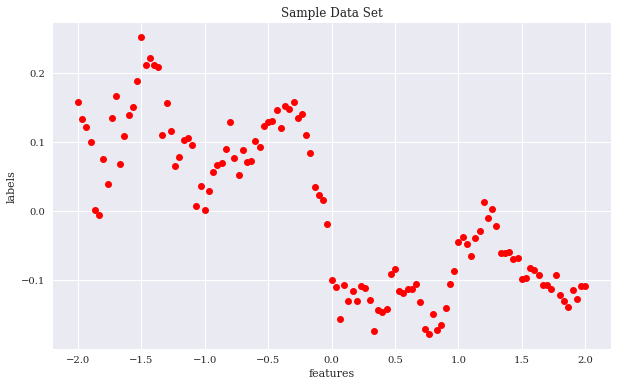

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro')
plt.title('Sample Data Set')
plt.xlabel('features')
plt.ylabel('labels');
# plt.savefig('../../images/ch05/figure_ml_01_.png');

### Success
The measure of success for estimation problems in general is the MSE, as used in Chapter 1. Based on the MSE, success is judged given the labels data as the relevant benchmark and the predicted values of an algorithm after having been exposed to the data set or parts of it. As in Chapter 1, two algorithms are considered in this and the following sections: OLS regression and neural networks.

First is OLS regression. The application is straightforward, as the following Python code illustrates. The regression result is shown in Figure 5-3 for a regression including monomials up to the fifth order. The resulting MSE is also calculated:

In [11]:
def MSE(l, p):
    return np.mean((l - p) ** 2)

In [12]:
reg = np.polyfit(f, l, deg=5)
reg

array([-0.01910626, -0.0147182 ,  0.10990388,  0.06007211, -0.20833598,
       -0.03275423])

In [13]:
p = np.polyval(reg, f)

In [14]:
MSE(l, p)

0.003416642295737103

1. The function MSE calculates the mean-squared error.

2. The fitting of the OLS regression model up to and including fifth-order monomials.

3. The prediction by the OLS regression model given the optimal parameters.

4. The MSE value given the prediction values.

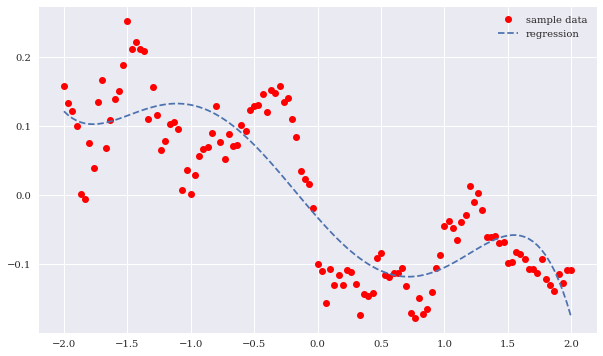

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='regression')
plt.legend();
# plt.savefig('../../images/ch05/figure_ml_02.png');

OLS regression is generally solved analytically. Therefore, no iterated learning takes place. However, one can simulate a learning procedure by gradually exposing the algorithm to more data. The following Python code implements OLS regression and prediction, starting with a few samples only and gradually increasing the number to finally reach the complete length of the data set. The regression step is implemented based on the smaller sub-sets, whereas the prediction steps are implemented based on the whole features data in each case. In general, the MSE drops significantly when increasing the training data set:

In [16]:
for i in range(10, len(f) + 1, 20):
    reg = np.polyfit(f[:i], l[:i], deg=3)
    p = np.polyval(reg, f)
    mse = MSE(l, p)
    print(f'{i:3d} | MSE={mse}')

 10 | MSE=248628.10681642237
 30 | MSE=731.9382249304651
 50 | MSE=12.236088505004465
 70 | MSE=0.7410590619743301
 90 | MSE=0.0057430617304093275
110 | MSE=0.006492800939555582


1. Regression step based on data sub-set

2. Prediction step based on the complete data set

3. Resulting MSE value

Second is the neural network. The application to the sample data is again straightforward and similar to the case in Chapter 1. Figure 5-4 shows how the neural network approximates the sample data:

In [20]:
import tensorflow as tf
#tf.random.set_seed(100)

In [21]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [22]:
model = Sequential()  
model.add(Dense(256, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear')) # <1>
model.compile(loss='mse', optimizer='rmsprop')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [24]:
%time model.fit(f, l, epochs=1500, verbose=False)

CPU times: user 17.4 s, sys: 1.01 s, total: 18.4 s
Wall time: 12.9 s


In [25]:
p = model.predict(f).flatten()

In [26]:
MSE(l, p)

0.0031041959261091196

1. The neural network is a shallow network with a single hidden layer.

2. The fitting step with a relatively high number of epochs.

3. The prediction step that also flattens the ndarray object.

4. The resulting MSE value for the DNN prediction.

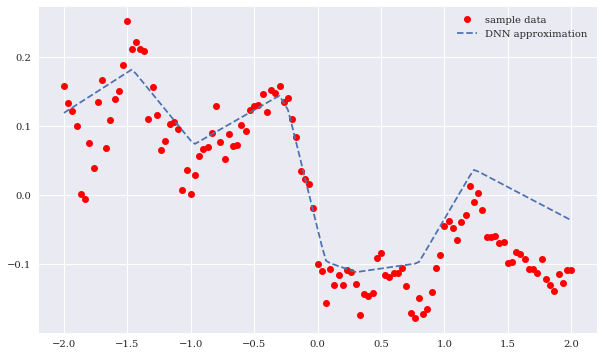

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();
# plt.savefig('../../images/ch05/figure_ml_03.png');

With the Keras package, the MSE values are stored after every learning step. Figure 5-5 shows how the MSE value (“loss”) decreases on average (as far as one can tell from the plot) with the increasing number of epochs over which the neural network is trained:



In [28]:
import pandas as pd

In [29]:
res = pd.DataFrame(model.history.history)

In [30]:
res.tail()

loss
1495  0.001960
1496  0.001212
1497  0.001342
1498  0.001298
1499  0.001477

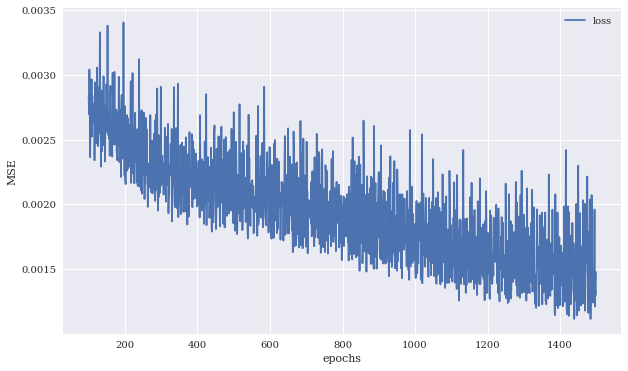

In [31]:
res.iloc[100:].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');
# plt.savefig('../../images/ch05/figure_ml_04.png');

### Capacity
The capacity of a model or algorithm defines what types of functions or relationships the model or algorithm can basically learn. In the case of OLS regression based on monomials only, there is only one parameter that defines the capacity of the model: the degree of the highest monomial to be used. If this degree parameter is set to deg=3, the OLS regression model can learn functional relationships of constant, linear, quadratic, or cubic type. The higher the parameter deg is, the higher the capacity of the OLS regression model will be.

The following Python code starts at deg=1 and increases the degree in increments of two. The MSE values monotonically decrease with the increasing degree parameter. Figure 5-6 shows the regression lines for all degrees considered:

In [32]:
reg = {}
for d in range(1, 12, 2):
    reg[d] = np.polyfit(f, l, deg=d)
    p = np.polyval(reg[d], f)
    mse = MSE(l, p)
    print(f'{d:2d} | MSE={mse}')

 1 | MSE=0.005322474034260404
 3 | MSE=0.004353110724143185
 5 | MSE=0.003416642295737103
 7 | MSE=0.0027389501772354012
 9 | MSE=0.0014119616263308405
11 | MSE=0.0012651237868752442


Regression step for different values for deg

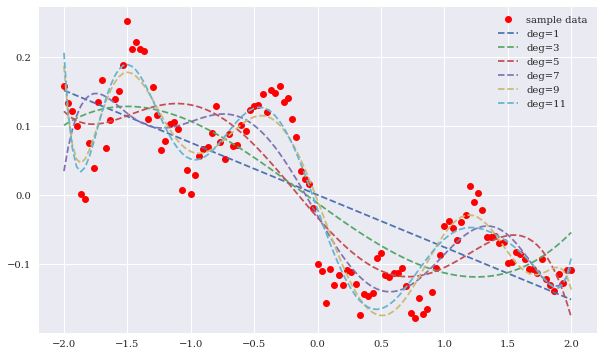

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
for d in reg:
    p = np.polyval(reg[d], f)
    plt.plot(f, p, '--', label=f'deg={d}')
plt.legend();
# plt.savefig('../../images/ch05/figure_ml_05.png');

The capacity of a neural network depends on a number of hyperparameters. Among them are, in general, the following:

* Number of hidden layers
* Number of hidden units for each hidden layer

Together, these two hyperparameters define the number of trainable parameters (weights) in the neural network. The neural network model in the previous section has a relatively low number of trainable parameters. Adding, for example, just one more layer of the same size increases the number of trainable parameters significantly. Although the number of training epochs may need to be increased, the MSE value decreases significantly for the neural network with the higher capacity, and the fit also seems much better visually, as the following figure shows:



In [36]:
def create_dnn_model(hl=1, hu=256):
    ''' Function to create Keras DNN model.
    
    Parameters
    ==========
    hl: int
        number of hidden layers
    hu: int
        number of hidden units (per layer)
    '''
    model = Sequential()
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [37]:
model = create_dnn_model(3)

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [39]:
%time model.fit(f, l, epochs=2500, verbose=False)

CPU times: user 8min 52s, sys: 12.1 s, total: 9min 4s
Wall time: 5min 52s


In [40]:
p = model.predict(f).flatten()

In [41]:
MSE(l, p)

0.0004947471643907167

1. Adds potentially many layers to the neural network

2. A deep neural network with three hidden layers

3. The summary shows the increased number of trainable parameters (increased capacity)

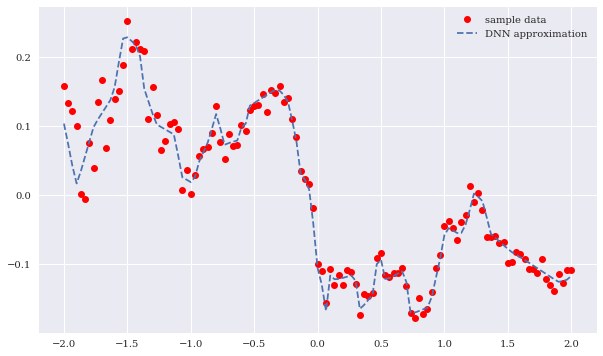

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();
# plt.savefig('../../images/ch05/figure_ml_06.png');

### Evaluation
In the previous sections, the analysis focuses on the performance of estimation algorithms on the sample data set as a whole. As a general rule, the capacity of the model or algorithm directly influences its performance when training and evaluating it on the same data set. However, this is the “simple and easy case” in ML. The more complex and interesting case is when a trained model or algorithm shall be used for a generalization on data that the model or algorithm has not seen before. Such a generalization can, for example, be the prediction (estimation) of a future stock price, given the history of stock prices, or the classification of potential debtors as “creditworthy” or “not creditworthy,” given the data from existing debtors.

Although the term prediction is often used freely in the context of estimations, given the features data set used for training, a real prediction probably entails predicting something not known up front and never seen before. Again, the prediction of a future stock price is a good example for a real prediction in a temporal sense.

In general, a given data set is divided into sub-sets that each have different purposes:

Training data set
This is the sub-set used for the training of the algorithm.

Validation data set
This is the sub-set used for validating the performance of the algorithm during training—and this data set is different from the training data set.

Test data set
This is the sub-set on which the trained algorithm is only tested after the training is finished.

Insights that are gained by applying a (currently) trained algorithm on the validation data set might reflect on the training itself (for example, by adjusting the hyperparameters of a model). On the other hand, the idea is that insights from testing the trained algorithm on the test data set shall not be reflected in the training itself or the hyperparameters.

The following Python code chooses, somewhat arbitrarily, 25% of the sample data for testing; the model or algorithm will not see this data before the training (learning) is finished. Similarly, 25% of the sample data is reserved for validation; this data is used to monitor performance during the training step and possibly during many learning iterations. The remaining 50% is used for the training (learning) itself.1 Given the sample data set, it makes sense to apply shuffling techniques to populate all sample data sub-sets randomly:



In [38]:
te = int(0.25 * len(f))
va = int(0.25 * len(f))

In [39]:
np.random.seed(100)
ind = np.arange(len(f))
np.random.shuffle(ind)

In [40]:
ind_te = np.sort(ind[:te])
ind_va = np.sort(ind[te:te + va])
ind_tr = np.sort(ind[te + va:])

In [41]:
f_te = f[ind_te]
f_va = f[ind_va]
f_tr = f[ind_tr]

In [42]:
l_te = l[ind_te]
l_va = l[ind_va]
l_tr = l[ind_tr]

1. Number of test data set samples
2. Number of validation data set samples
3. Randomized index for complete data set
4. Resulting sorted indexes for the data sub-sets
5. Resulting features data sub-sets
6. Resulting labels data sub-sets


**RANDOMIZED SAMPLING**
*The randomized population of training, validation, and test data sets is a common and useful technique for data sets that are neither sequence-like nor temporal in nature. However, when one is dealing, say, with a financial time series, shuffling the data is generally to be avoided because it breaks up temporal structures and sneaks foresight bias into the process by using, for example, later samples for training and implementing the testing on earlier samples.*

Based on the training and validation data sub-sets, the following Python code implements a regression for different deg parameter values and calculates the MSE values for the predictions on both data sub-sets. Although the MSE values on the training data set decrease monotonically, the MSE values on the validation data set often reach a minimum for a certain parameter value and then increase again. This phenomenon indicates what is called overfitting. Figure 5-8 shows the regression fits for the different values of deg and compares the fits for both the training data and validation data sets:

In [43]:
reg = {}
mse = {}
for d in range(1, 22, 4):
    reg[d] = np.polyfit(f_tr, l_tr, deg=d)
    p = np.polyval(reg[d], f_tr)
    mse_tr = MSE(l_tr, p)
    p = np.polyval(reg[d], f_va)
    mse_va = MSE(l_va, p)
    mse[d] = (mse_tr, mse_va)
    print(f'{d:2d} | MSE_tr={mse_tr:7.5f} | MSE_va={mse_va:7.5f}')

 1 | MSE_tr=0.00574 | MSE_va=0.00492
 5 | MSE_tr=0.00375 | MSE_va=0.00273
 9 | MSE_tr=0.00132 | MSE_va=0.00243
13 | MSE_tr=0.00094 | MSE_va=0.00183
17 | MSE_tr=0.00060 | MSE_va=0.00153
21 | MSE_tr=0.00046 | MSE_va=0.00837


1. MSE value for the training data set
2. MSE value for the validation data set

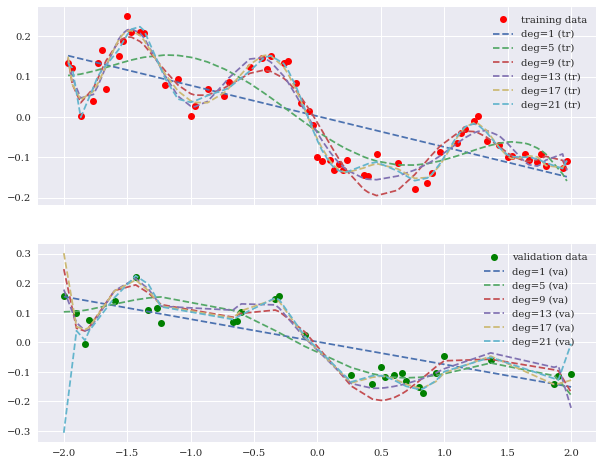

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
ax[1].plot(f_va, l_va, 'go', label='validation data')
for d in reg:
    p = np.polyval(reg[d], f_tr)
    ax[0].plot(f_tr, p, '--', label=f'deg={d} (tr)')
    p = np.polyval(reg[d], f_va)
    plt.plot(f_va, p, '--', label=f'deg={d} (va)')
ax[0].legend()
ax[1].legend();
# plt.savefig('../../images/ch05/figure_ml_07.png');

With Keras and the neural network model, the validation data set performance can be monitored for every single learning step. One can also use callback functions to stop the model training early when no further improvements, say, in the performance on the training data set, are observed. The following Python code makes use of such a callback function. Figure 5-9 shows the predictions of the neural network for the training and validation data sets:

In [45]:
from keras.callbacks import EarlyStopping

In [46]:
model = create_dnn_model(2, 256)

In [47]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=100,
                          restore_best_weights=True)]

In [48]:
%%time
model.fit(f_tr, l_tr, epochs=3000, verbose=False,
          validation_data=(f_va, l_va),
          callbacks=callbacks)

CPU times: user 8.07 s, sys: 1.33 s, total: 9.4 s
Wall time: 4.81 s


1. Learning is stopped based on training data MSE value.

2. It is only stopped after a certain number of epochs that do not show an improvement.

3. The best weights are restored when the learning is stopped.

4. The validation data sub-sets are specified.

5. The callback function is passed to the fit() method.

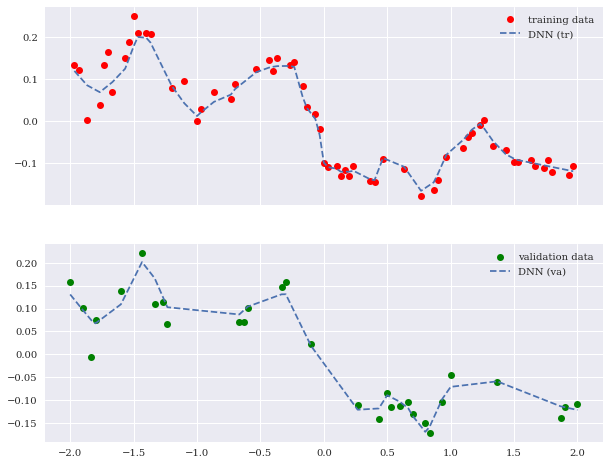

In [49]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
p = model.predict(f_tr)
ax[0].plot(f_tr, p, '--', label=f'DNN (tr)')
ax[0].legend()
ax[1].plot(f_va, l_va, 'go', label='validation data')
p = model.predict(f_va)
ax[1].plot(f_va, p, '--', label=f'DNN (va)')
ax[1].legend();
# plt.savefig('../../images/ch05/figure_ml_08.png');

Keras allows analysis of the change in the MSE values on both data sets for every single epoch the model has been trained in. Figure 5-10 shows that the MSE values decrease with the increasing number of training epochs, although only on average and not monotonically:

In [50]:
res = pd.DataFrame(model.history.history)

In [51]:
res.tail()

val_loss      loss
1375  0.000854  0.000544
1376  0.000685  0.000473
1377  0.001326  0.000942
1378  0.001026  0.000867
1379  0.000710  0.000500

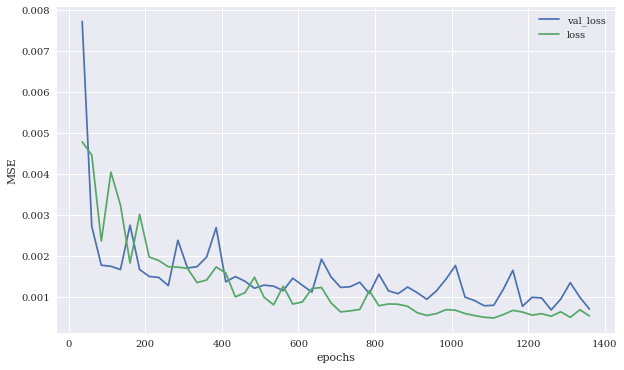

In [52]:
res.iloc[35::25].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');
# plt.savefig('../../images/ch05/figure_ml_09.png');

In the case of OLS regression, one would probably choose a high—but not too high—value for the degree parameter, such as deg=9. The parameterization of the neural network model automatically gives the best model configuration at the end of the training. Figure 5-10 compares the predictions of both models to each other and to the test data set. Given the nature of the sample data, the somewhat better test data set performance of the neural network should not come as a surprise:

In [53]:
p_ols = np.polyval(reg[5], f_te)
p_dnn = model.predict(f_te).flatten()

In [54]:
MSE(l_te, p_ols)

0.0038960346771028356

In [55]:
MSE(l_te, p_dnn)

0.000705705678438721

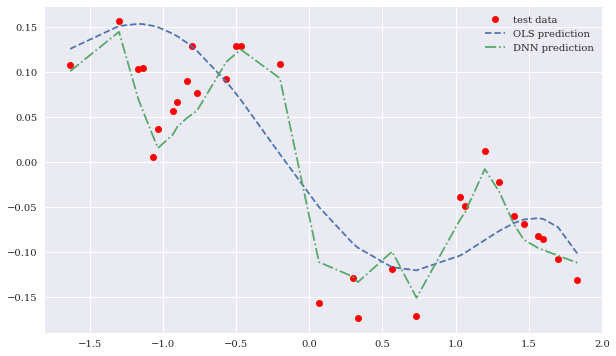

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(f_te, l_te, 'ro', label='test data')
plt.plot(f_te, p_ols, '--', label='OLS prediction')
plt.plot(f_te, p_dnn, '-.', label='DNN prediction');
plt.legend();
# plt.savefig('../../images/ch05/figure_ml_10.png');

***Bias and Variance***
A major problem in ML in general and when applying ML algorithms to financial data in particular is the problem of overfitting. A model is overfitting its training data when the performance is worse on the validation and test data than on the training data. An example using OLS regression can illustrate the problem both visually and numerically.

The following Python code uses smaller sub-sets for both training and validation and implements a linear regression, as well as one of higher order. The linear regression fit, as shown in Figure 5-12, has a high bias on the training data set; absolute differences between predictions and labels data are relatively high. The higher-order fit shows a high variance. It hits all training data points exactly, but the fit itself varies significantly to achieve the perfect fit:

In [57]:
f_tr = f[:20:2]
l_tr = l[:20:2]

In [58]:
f_va = f[1:20:2]
l_va = l[1:20:2]

In [59]:
reg_b = np.polyfit(f_tr, l_tr, deg=1)

In [60]:
reg_v = np.polyfit(f_tr, l_tr, deg=9, full=True)[0]

In [61]:
f_ = np.linspace(f_tr.min(), f_va.max(), 75)

1. Smaller features data sub-set

2. Smaller labels data sub-set

3. High bias OLS regression (linear)

4. High variance OLS regression (higher order)

5. Enlarged features data set for plotting

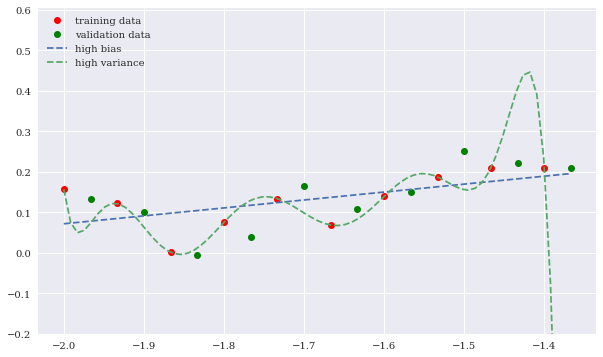

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(f_tr, l_tr, 'ro', label='training data')
plt.plot(f_va, l_va, 'go', label='validation data')
plt.plot(f_, np.polyval(reg_b, f_), '--', label='high bias')
plt.plot(f_, np.polyval(reg_v, f_), '--', label='high variance')
plt.ylim(-0.2)
plt.legend(loc=2);
# plt.savefig('../../images/ch05/figure_ml_11.png');

The above shows that a high bias fit performs worse in the example than a high variance fit on the training data. But the high variance fit, which is overfitting here to a large extent, performs much worse on the validation data. This can be illustrated by comparing performance measures for all cases. The following Python code calculates not only the MSE values, but also the R2
 values:

In [63]:
from sklearn.metrics import r2_score

In [64]:
def evaluate(reg, f, l):
    p = np.polyval(reg, f)
    bias = np.abs(l - p).mean()
    var = p.var()
    msg = f'MSE={MSE(l, p):.4f} | R2={r2_score(l, p):9.4f} | '
    msg += f'bias={bias:.4f} | var={var:.4f}'
    print(msg)

In [65]:
evaluate(reg_b, f_tr, l_tr)

MSE=0.0026 | R2=   0.3484 | bias=0.0423 | var=0.0014


In [66]:
evaluate(reg_b, f_va, l_va)

MSE=0.0032 | R2=   0.4498 | bias=0.0460 | var=0.0014


In [67]:
evaluate(reg_v, f_tr, l_tr)

MSE=0.0000 | R2=   1.0000 | bias=0.0000 | var=0.0040


In [68]:
evaluate(reg_v, f_va, l_va)

MSE=0.8752 | R2=-149.2658 | bias=0.3565 | var=0.7539


1. Model bias as mean absolute differences

2. Model variance as variance of model predictions

3. Performance of high bias model on training data

4. Performance of high bias model on validation data

5. Performance of high variance model on training data

6. Performance of high variance model on validation data

The results show that performance of the high bias model is roughly comparable on both the training and validation data sets. By contrast, the performance of the high variance model is perfect on the training data and pretty bad on the validation data.

***Cross-Validation***
A standard approach to avoid overfitting is cross-validation, during which multiple training and validation data populations are tested. The scikit-learn package provides functionality to implement cross-validation in a standardized way. The function cross_val_score can be applied to any scikit-learn model object.

The following code implements the OLS regression approach on the complete sample data set, using a polynomial OLS regression model from scikit-learn. The five-fold cross-validation is implemented for different degrees for the highest polynomial. The cross-validation scores become, on average, worse the higher the highest degree is in the regression. Particularly bad results are observed when the first 20% of the data is used for validation (data on the left-hand side in Figure 5-3) or the final 20% of the data is used (data on the right-hand side in Figure 5-3). Similarly, the best validation scores are observed for the middle 20% of the sample data set:

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [70]:
def PolynomialRegression(degree=None, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [71]:
np.set_printoptions(suppress=True,
        formatter={'float': lambda x: f'{x:12.2f}'})

In [72]:
print('\nCross-validation scores')
print(74 * '=')
for deg in range(0, 10, 1):
    model = PolynomialRegression(deg)
    cvs = cross_val_score(model, f.reshape(-1, 1), l, cv=5)
    print(f'deg={deg} | ' + str(cvs.round(2)))


Cross-validation scores
deg=0 | [       -6.07        -7.34        -0.09        -6.32        -8.69]
deg=1 | [       -0.28        -1.40         0.16        -1.66        -4.62]
deg=2 | [       -3.48        -2.45         0.19        -1.57       -12.94]
deg=3 | [       -0.00        -1.24         0.32        -0.48       -43.62]
deg=4 | [     -222.81        -2.88         0.37        -0.32      -496.61]
deg=5 | [     -143.67        -5.85         0.49         0.12     -1241.04]
deg=6 | [    -4038.96       -14.71         0.49        -0.33      -317.32]
deg=7 | [    -9937.83       -13.98         0.64         0.22    -18725.61]
deg=8 | [    -3514.36       -11.22        -0.15        -6.29   -298744.18]
deg=9 | [    -7454.15        -0.91         0.15        -0.41    -13580.75]


1. Creates a polynomial regression model class

2. Adjusts the default printing settings for numpy

3. Implements the five-fold cross-validation

Keras provides wrapper classes to use Keras model objects with scikit-learn functionality, such as the cross_val_score function. The following example uses the KerasRegressor class to wrap the neural network models and to apply the cross-validation to them. The cross-validation scores are better throughout for the two networks tested when compared to the OLS regression cross-validation scores. The neural network capacity does not play too large a role in this example:

In [73]:
np.random.seed(100)
tf.random.set_seed(100)
from keras.wrappers.scikit_learn import KerasRegressor

In [74]:
model = KerasRegressor(build_fn=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=1, hu=36)

In [75]:
%time cross_val_score(model, f, l, cv=5)

CPU times: user 18.6 s, sys: 2.17 s, total: 20.8 s
Wall time: 14.6 s


array([       -0.02,        -0.01,        -0.00,        -0.00,
              -0.01])

In [76]:
model = KerasRegressor(build_fn=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=3, hu=256)

In [77]:
%time cross_val_score(model, f, l, cv=5)

CPU times: user 1min 5s, sys: 11.6 s, total: 1min 16s
Wall time: 30.1 s


array([       -0.08,        -0.00,        -0.00,        -0.00,
              -0.05])

1. Wrapper class for neural network with low capacity

2. Cross-validation for neural network with low capacity

3. Wrapper class for neural network with high capacity

4. Cross-validation for neural network with high capacity

***AVOIDING OVERFITTING***
Overfitting—when a model performs much better on a training data set than on the validation and test data sets—is to be avoided in ML in general and in finance in particular. Proper evaluation procedures and analyses, such as cross-validation, help in preventing overfitting and in finding, for example, an adequate model capacity.

***Conclusions***

This chapter presents a blueprint for a machine learning process. The main elements presented are as follows:

*Learning*
What exactly is meant by machine learning?

*Data*
What raw data and what (preprocessed) features and labels data is to be used?

*Success*
Given the problem as defined indirectly by the data (estimation, classification, etc.), what is the appropriate measure of success?

*Capacity*
Which role does the model capacity play, and what might be an adequate capacity given the problem at hand?

*Evaluation*
How shall the model performance be evaluated given the purpose of the trained model?

*Bias and variance*
Which models are better suited for the problem at hand: those with rather high bias or rather high variance?

*Cross-validation*
For non-sequence-like data sets, how does the model perform when cross-validated on different configurations for the training and validation data sub-sets used?

This blueprint is applied loosely in subsequent chapters to a number of real-world financial use cases. For more background information and details about machine learning as a process, refer to the references listed at the end of this chapter.

***References***
Books and papers cited in this chapter:

Chollet, François. 2017. Deep Learning with Python. Shelter Island: Manning.

Domingos, Pedro. 2015. The Master Algorithm: How the Quest for the Ultimate Learning Machine Will Remake Our World. New York: Basic Books.

Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. Cambridge: MIT Press. http://deeplearningbook.org.

Harari, Yuval Noah. 2015. Homo Deus: A Brief History of Tomorrow. London: Harvill Secker.

Mitchell, Tom M. 1997. Machine Learning. New York: McGraw-Hill.

VanderPlas, Jake. 2017. Python Data Science Handbook. Sebastopol: O’Reilly.

